In [1]:
import pandas as pd
import numpy as np
# 10. モデル構築の準備
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns


# 1. CSVファイルからデータを読み込む
# 日経平均株価データを 'japan_2022.csv' から読み込む
df = pd.read_csv('japan_2022.csv')

# データの先頭5行を表示して確認する
print("データの先頭5行:")
print(df.head())

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


データの先頭5行:
                  Date         Open         High          Low        Close  \
0  2022-01-04 00:00:00  29098.41016  29323.78906  28954.56055  29301.78906   
1  2022-01-05 00:00:00  29288.80078  29388.16016  29204.44922  29332.16016   
2  2022-01-06 00:00:00  29136.75000  29158.94922  28487.86914  28487.86914   
3  2022-01-07 00:00:00  28711.52930  28813.08984  28293.69922  28478.56055   
4  2022-01-11 00:00:00  28380.90039  28473.47070  28089.49023  28222.48047   

     Adj Close    Volume  
0  29301.78906  66000000  
1  29332.16016  78600000  
2  28487.86914  71600000  
3  28478.56055  75200000  
4  28222.48047  73700000  


In [2]:
# 欠損値の確認
# 各列の欠損値の数を表示
print("\n欠損値の確認:")
print(df.isnull().sum())


# 2. 欠損値の補完
# 'ffill' は前の行の値で欠損値を埋める方法
df.fillna(method='ffill', inplace=True)

# 欠損値の補完後、再度欠損値の確認
print("\n欠損値補完後の確認:")
print(df.isnull().sum())


# 3. 移動平均の計算
# 5日, 10日, 20日の移動平均を計算して、特徴量として追加
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()


# 4. ボラティリティの計算
# 5日のボラティリティ（標準偏差）を計算して、特徴量として追加
df['Volatility'] = df['Close'].rolling(window=5).std()


# 5. 時間に関連する特徴量の追加
# 'Date'列を日時型に変換
df['Date'] = pd.to_datetime(df['Date'])
# 曜日 (0=月曜日, 6=日曜日)
df['DayOfWeek'] = df['Date'].dt.dayofweek
# 月 (1=1月, 12=12月)
df['Month'] = df['Date'].dt.month
# 週番号 (1から52または53)
df['WeekOfYear'] = df['Date'].dt.isocalendar().week


# 6. テクニカル指標の計算
# RSI (Relative Strength Index) の計算
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 14日間のRSIを計算して追加
df['RSI'] = calculate_rsi(df)

# ボリンジャーバンドの計算
def calculate_bollinger_bands(data, window=20):
    sma = data['Close'].rolling(window=window).mean()
    rstd = data['Close'].rolling(window=window).std()
    upper_band = sma + 2 * rstd
    lower_band = sma - 2 * rstd
    return upper_band, lower_band

# 20日間のボリンジャーバンドを計算して追加
df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df)

# MACD (Moving Average Convergence Divergence) の計算
# 12日EMA (Exponential Moving Average) と 26日EMA の差分を計算
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
# 9日EMA のシグナルラインを計算して追加
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


# 7. ファンダメンタル指標の追加
# 出来高変化率 (Volume Change Rate) の計算
df['Volume_Change'] = df['Volume'].pct_change()
# 出来高の移動平均 (5日, 10日) の計算
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()


# 8. 株価の変動率の計算
# 日次変動率 (Daily Price Change) の計算
df['Daily_Change'] = df['Close'].pct_change()
# 高値と安値の変動率 (High-Low Range) の計算
df['High_Low_Range'] = (df['High'] - df['Low']) / df['Low']


# 9. 目的変数の設定
# 翌日の終値を目的変数として追加
df['Next_Close'] = df['Close'].shift(-1)
# 最後の行は目的変数がないため削除
df.dropna(inplace=True)

# データの先頭5行を表示して確認
print("\n特徴量を追加したデータの先頭5行:")
print(df.head())


欠損値の確認:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

欠損値補完後の確認:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

特徴量を追加したデータの先頭5行:
         Date         Open         High          Low        Close  \
19 2022-02-01  27167.14063  27410.78906  27016.71094  27078.48047   
20 2022-02-02  27302.99023  27564.61914  27289.16016  27533.59961   
21 2022-02-03  27330.96094  27357.33008  27165.92969  27241.31055   
22 2022-02-04  27095.90039  27455.98047  27075.99023  27439.99023   
23 2022-02-07  27327.63086  27369.67969  27085.32031  27248.86914   

      Adj Close    Volume          MA_5         MA_10         MA_20  ...  \
19  27078.48047  81100000  26795.886328  27146.156055  27862.712989  ...   
20  27533.59961  85200000  26900.340234  27152.792969  27774.303517  ...   
21  27241.31055  81100000  27114.542188  27099.631055  27669.761036  ...   
22  2

In [3]:
# 10. モデル構築の準備
# 説明変数（特徴量）の選択
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'Volatility', 
        'DayOfWeek', 'Month', 'WeekOfYear', 'RSI', 'Upper_Band', 'Lower_Band', 'MACD', 
        'MACD_Signal', 'Volume_Change', 'Volume_MA_5', 'Volume_MA_10', 'Daily_Change', 
        'High_Low_Range']]
# 目的変数（ターゲット）の選択
y = df['Next_Close']

# 訓練データとテストデータに分割（80%訓練データ、20%テストデータ）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42)

# モデルを訓練データで学習
model.fit(X_train, y_train)

# テストデータを用いて予測
y_pred = model.predict(X_test)

# 11.評価
# 平均二乗誤差（MSE）の計算
mse = mean_squared_error(y_test, y_pred)
# 平均絶対誤差（MAE）の計算
mae = mean_absolute_error(y_test, y_pred)

# 評価結果を表示
print("\nモデルの評価:")
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


モデルの評価:
Mean Squared Error: 75246.82122281307
Mean Absolute Error: 208.65868487555693


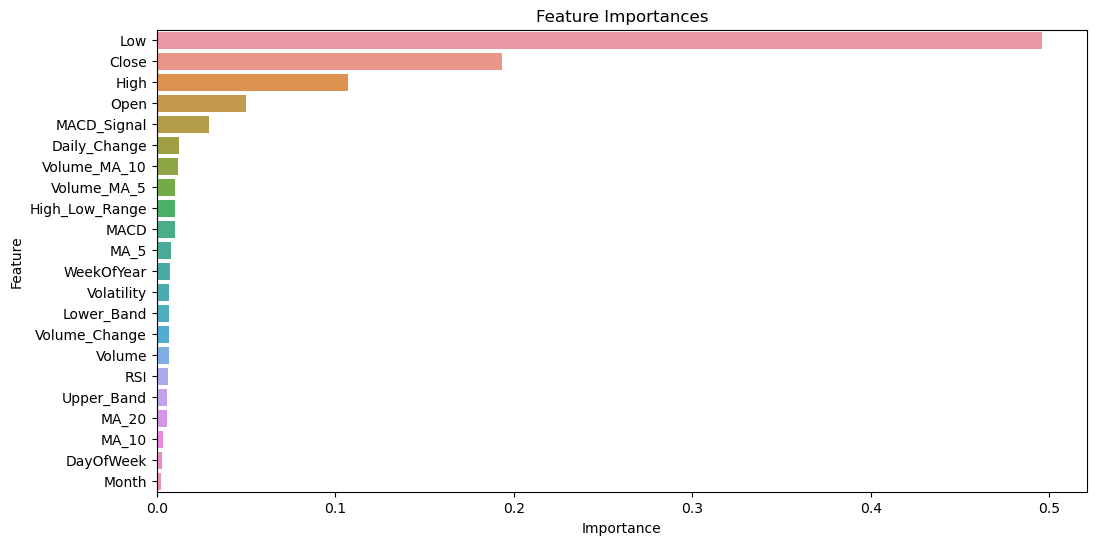

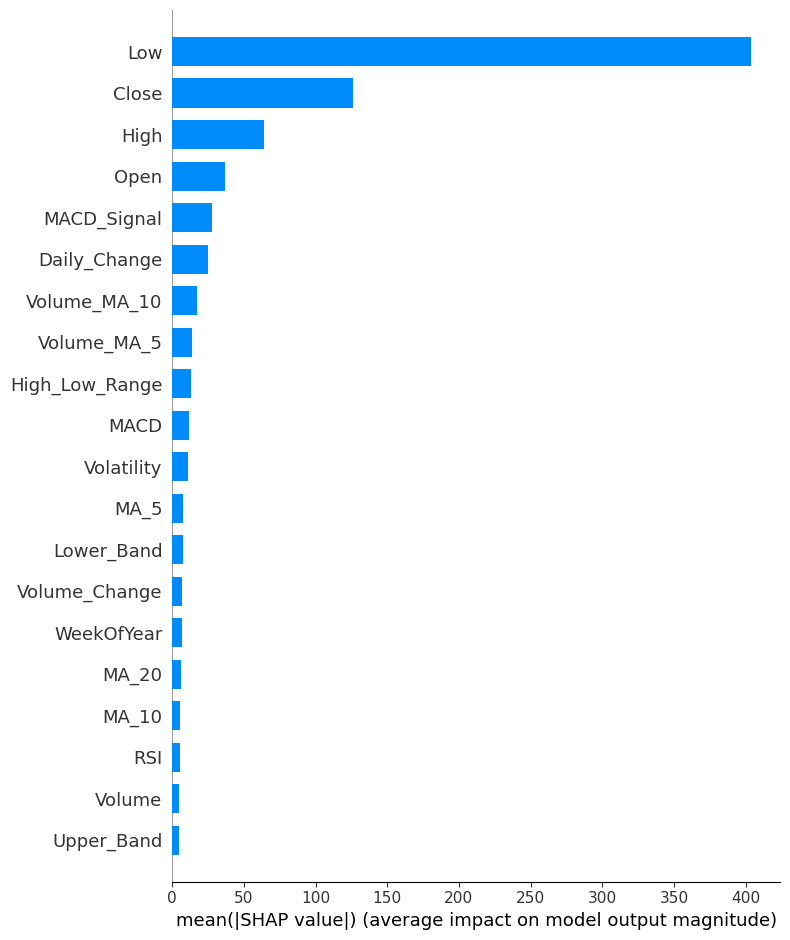

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


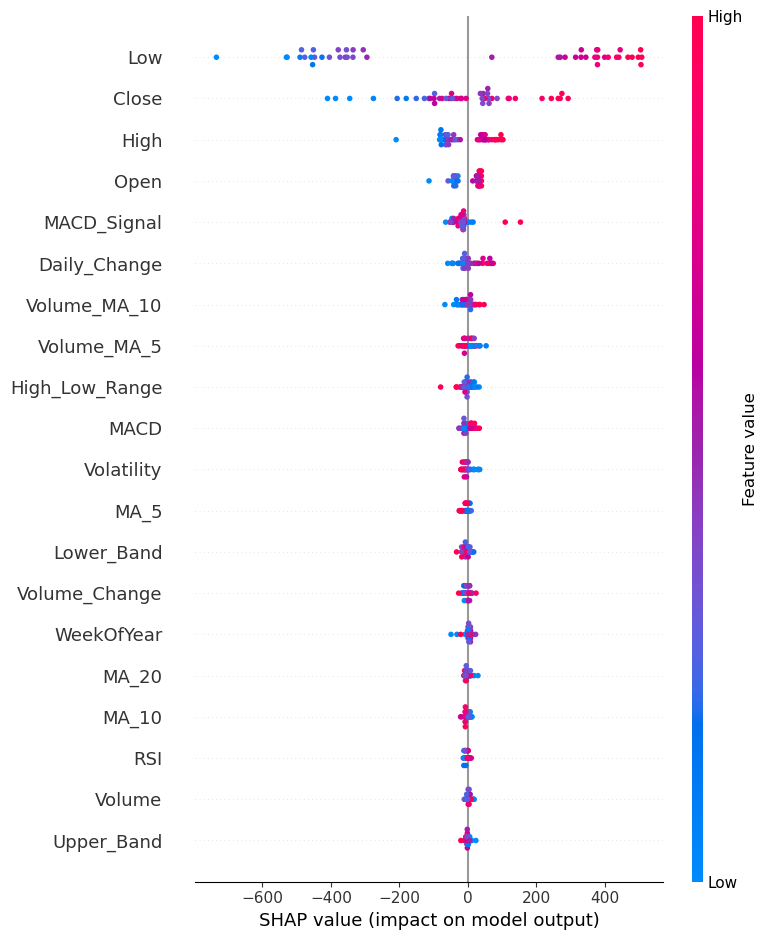

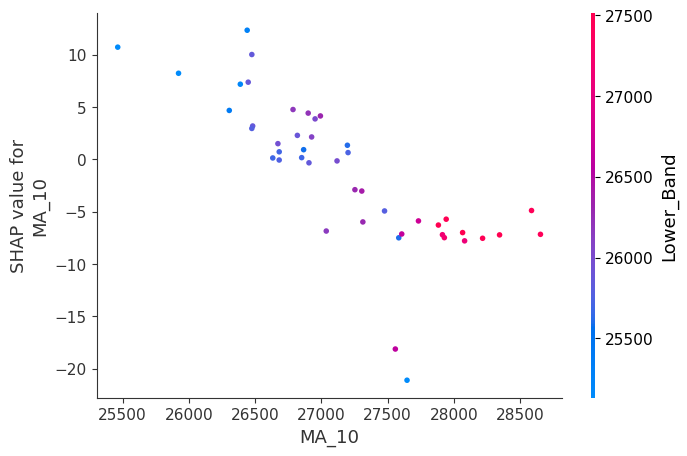

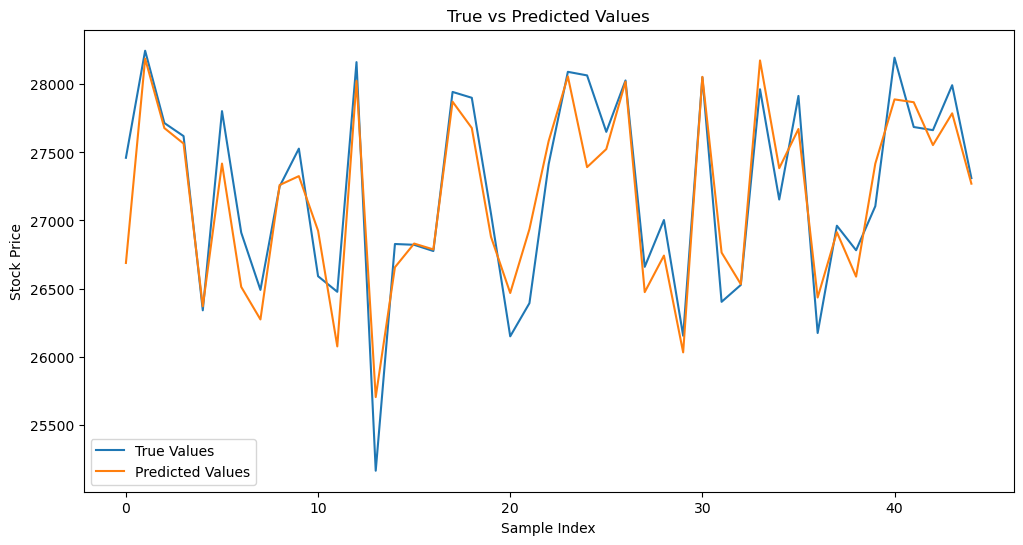

In [4]:
# 12. モデルの解釈
# 特徴量の重要度を取得
feature_importances = model.feature_importances_

# 特徴量の重要度をデータフレームに変換
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 特徴量の重要度を棒グラフで表示
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()


# 13. SHAP値の計算と可視化
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# 特定の予測のSHAP値を可視化
sample_index = 0  # 予測したいサンプルのインデックスを指定
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index])


# 14. SHAP Dependence Plot
# 特定の特徴量のSHAP値の散布図を表示
shap.dependence_plot("MA_10", shap_values, X_test)


# 15. 予測値の可視化
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.show()